# Age Prediction by Photo

Regression | Tensorflow Keras | Convolutional Neural Network: ResNet50

***

## Project descritpion

### The task

Build and evaluate a model for verifying people's age.

The supermarket chain XYZ would like to explore whether Data Science can help them adhere to alcohol laws by making sure they do not sell alcohol to people underage. The shops are equipped with cameras in the checkout area which are triggered when a person is buying alcohol. Computer vision methods can be used to determine age of a person from a photo.

### The dataset

In this task, used data that is publicly available.

The dataset is stored in the `/datasets/faces/` folder, where
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, Tenforflow's ImageDataGenerator will be used for data loading.

The label file can be loaded as an usual CSV file.

### Conditions

Define the necessary functions to train the model on the GPU platform and build a single script containing all of them along with the initialization section.

***

## Libraries and settings

In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
plt.style.use("seaborn")
sns.set_style("dark", {"axes.facecolor": ".95"})
sns.set_palette("mako")

# set default figure size
plt.rc("figure", figsize=(10,5))
%config InlineBackend.figure_format = "retina"

***

## EDA

### Read the data

In [3]:
labels = pd.read_csv("/datasets/faces/labels.csv")
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


### Look at the age distribution

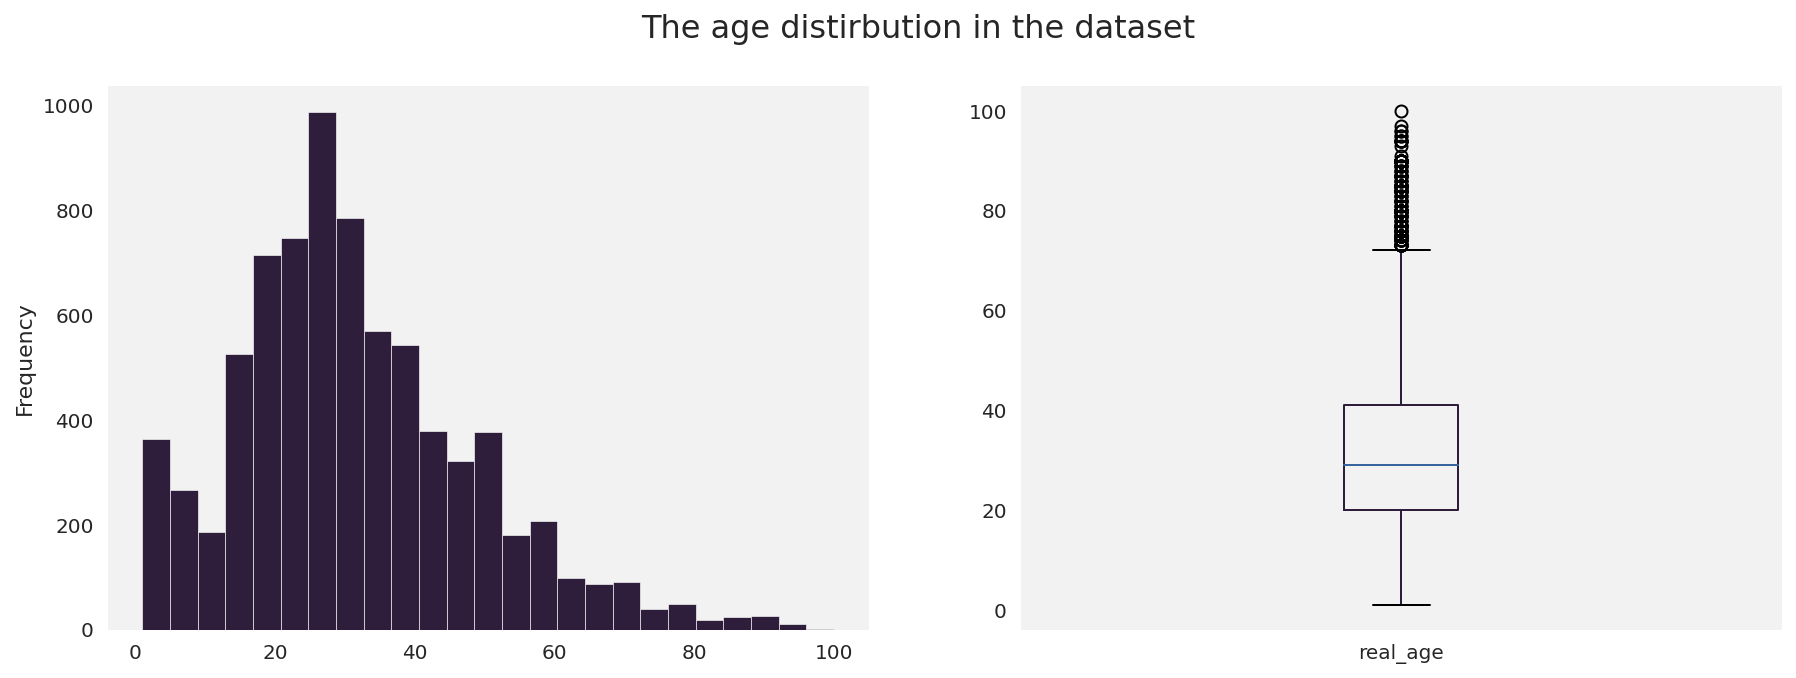

In [4]:
plt.figure(figsize=(15,5))
plt.suptitle("The age distirbution in the dataset", fontsize=16)

plt.subplot(121)
labels.real_age.plot(kind="hist", bins=25)

plt.subplot(122)
labels.real_age.plot(kind="box");

### Look at some photos

In [5]:
# initiate the image data generator
train_datagen = ImageDataGenerator(rescale=1./255)

# initiate the reader and its parameters 
train_gen_flow = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory="/datasets/faces/final_files/",
    x_col="file_name",
    y_col="real_age",
    target_size=(224,224),
    batch_size=32,
    class_mode="raw",
    seed=12345
)

Found 7591 validated image filenames.


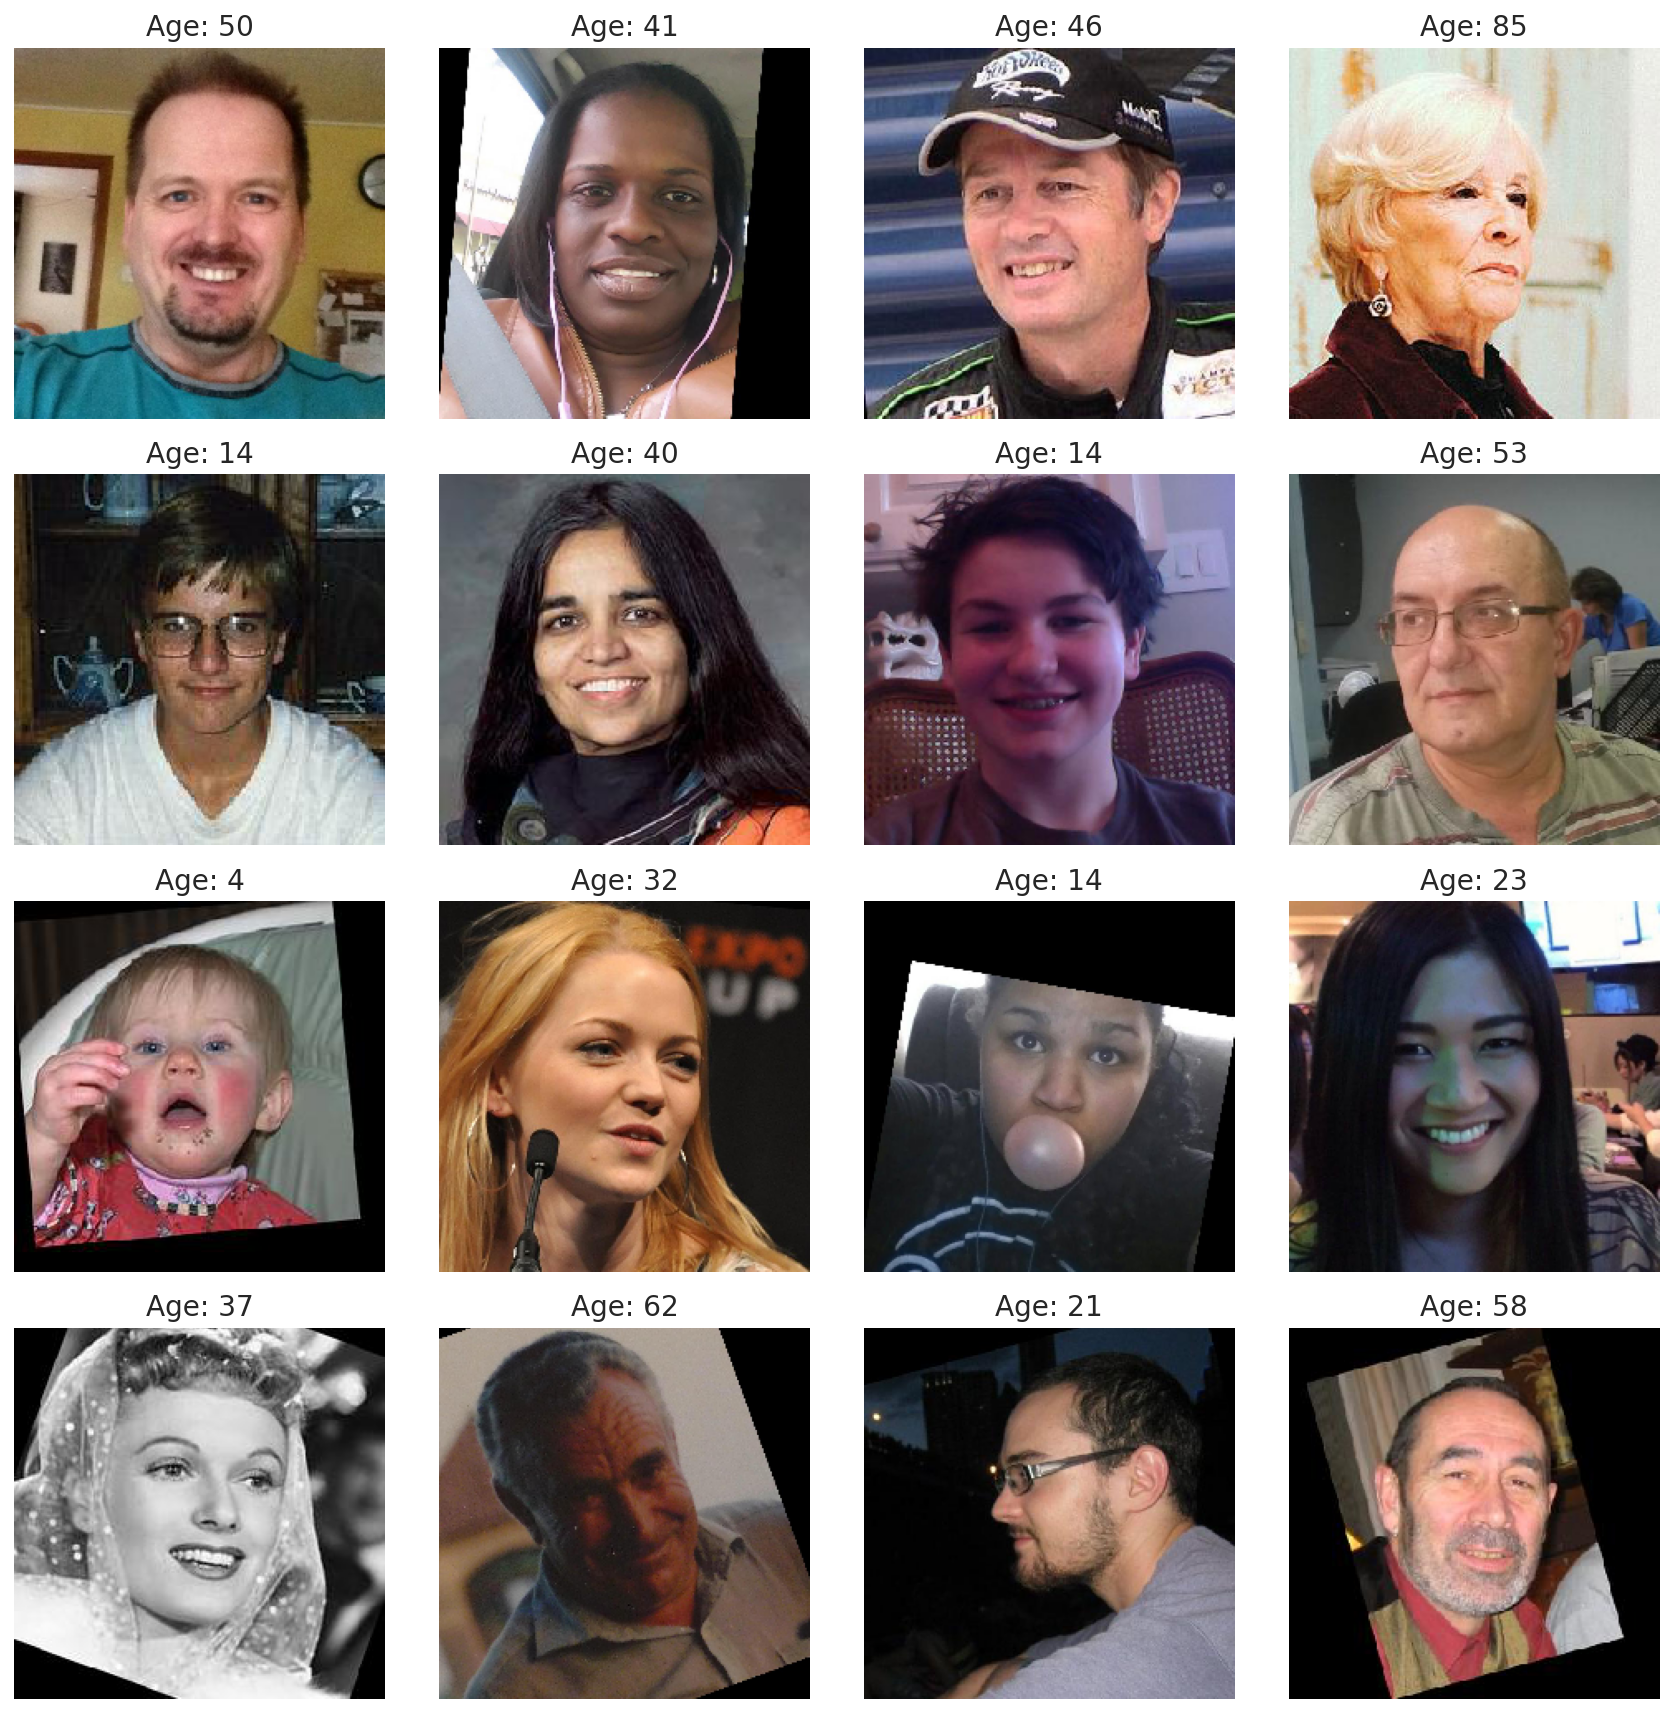

In [6]:
# select the batch
features = next(train_gen_flow)

fig = plt.figure(figsize=(12,12))

# plot a sample of images
for i in range(16):
    fig.add_subplot(4,4,i+1)
    plt.imshow(features[0][i])
    plt.title("Age: {}".format(features[1][i]), fontsize=14)
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

### Findings

- The age values distibution is normal, although there are some high age values that can be considered outlieres;
- The dataset of photos is diverse: there are photos of regular people and celebrities, snapshots from movies, kids' photos, photos from events, and profile pictures, taken with a digital camera or using film;
- The dataset was modified with augmentation technique;
  
The model's ability to read facial features may be hindered because of the diversity of the photographs. Also, some photographs in the data set have different brightness, contrast, and person's posture, than it will be when taking photos by cameras in the shop. 

***

## Modeling

Define the necessary functions to train the model on the GPU platform and build a single script containing all of them along with the initialization section.

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [8]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    labels = pd.read_csv("/datasets/faces/labels.csv")
    train_gen = ImageDataGenerator(rescale=1./255, validation_split=.25)
    
    train_gen_flow = train_gen.flow_from_dataframe(
        dataframe=labels,
        directory="/datasets/faces/final_files/",
        x_col="file_name",
        y_col="real_age",
        target_size=(224,224),
        batch_size=32,
        class_mode="raw",
        subset="training",
        seed=12345
    )

    return train_gen_flow

In [9]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    labels = pd.read_csv("/datasets/faces/labels.csv")
    test_gen = ImageDataGenerator(rescale=1./255, validation_split=.25)
    
    test_gen_flow = test_gen.flow_from_dataframe(
        dataframe=labels,
        directory="/datasets/faces/final_files/",
        x_col="file_name",
        y_col="real_age",
        target_size=(224,224),
        batch_size=32,
        class_mode="raw",
        subset="validation",
        seed=12345
    )

    return test_gen_flow

In [10]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    backbone = ResNet50(
        input_shape=input_shape, weights="imagenet", include_top=False
    )
    optimizer = Adam(lr=0.0001)
    model = Sequential()
    
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(.2))
    model.add(Dense(units=1, activation='relu'))
    
    model.compile(
        loss="mean_squared_error", optimizer=optimizer,
        metrics=["mean_absolute_error"]
    )

    return model

In [11]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    earlystop = EarlyStopping(patience=3)
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_mean_absolute_error', 
                                                patience=2, 
                                                verbose=1, 
                                                factor=0.5, 
                                                min_lr=0.00001)
    
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        callbacks=[earlystop, learning_rate_reduction]
    )

    return model

### Prepare the Script to Run on the GPU Platform

N.B.: The script should include the initialization section as well.

In [12]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

"""

import inspect

with open('run_model_on_gpu_v2.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

```
Train for 178 steps, validate for 60 steps
Epoch 1/20
178/178 - 63s - loss: 227.9050 - mean_absolute_error: 10.8228 - val_loss: 953.9773 - val_mean_absolute_error: 26.1170
Epoch 2/20
178/178 - 37s - loss: 60.3329 - mean_absolute_error: 5.9034 - val_loss: 797.5084 - val_mean_absolute_error: 23.2461
Epoch 3/20
178/178 - 37s - loss: 30.3866 - mean_absolute_error: 4.2475 - val_loss: 483.1002 - val_mean_absolute_error: 17.0382
Epoch 4/20
178/178 - 37s - loss: 19.9175 - mean_absolute_error: 3.4355 - val_loss: 116.0049 - val_mean_absolute_error: 8.1304
Epoch 5/20
178/178 - 37s - loss: 15.5967 - mean_absolute_error: 3.0374 - val_loss: 80.0225 - val_mean_absolute_error: 6.9487
Epoch 6/20
178/178 - 37s - loss: 12.6286 - mean_absolute_error: 2.7551 - val_loss: 71.1565 - val_mean_absolute_error: 6.2703
Epoch 7/20
178/178 - 37s - loss: 10.6139 - mean_absolute_error: 2.5089 - val_loss: 77.2828 - val_mean_absolute_error: 6.9106
Epoch 8/20

Epoch 00008: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
178/178 - 37s - loss: 9.9499 - mean_absolute_error: 2.3965 - val_loss: 76.9980 - val_mean_absolute_error: 6.8650
Epoch 9/20
178/178 - 37s - loss: 7.5930 - mean_absolute_error: 2.0295 - val_loss: 64.0994 - val_mean_absolute_error: 5.9971
Epoch 10/20
178/178 - 37s - loss: 2.8428 - mean_absolute_error: 1.2956 - val_loss: 62.6506 - val_mean_absolute_error: 5.9944
Epoch 11/20
178/178 - 37s - loss: 1.8787 - mean_absolute_error: 1.0360 - val_loss: 64.2967 - val_mean_absolute_error: 6.1454
Epoch 12/20
178/178 - 37s - loss: 1.7317 - mean_absolute_error: 0.9951 - val_loss: 61.9071 - val_mean_absolute_error: 5.9536
Epoch 13/20
178/178 - 37s - loss: 1.8417 - mean_absolute_error: 1.0103 - val_loss: 62.3462 - val_mean_absolute_error: 5.9485
Epoch 14/20
178/178 - 37s - loss: 1.8898 - mean_absolute_error: 1.0281 - val_loss: 62.5846 - val_mean_absolute_error: 5.9958
Epoch 15/20
178/178 - 37s - loss: 2.1211 - mean_absolute_error: 1.0854 - val_loss: 62.0229 - val_mean_absolute_error: 5.9269

60/60 - 9s - loss: 62.0229 - mean_absolute_error: 5.9269
Test MAE: 5.9269
```

***

## Conclusions

Trained on the current dataset, the model's prediction is on average 6 years off from the actual person's age. This is quite a big error, especially if the prediction is going to be used as an age validation before selling alcohol. With a more appropriate data, a better model could be built.